<a href="https://colab.research.google.com/github/daniellmarc/reweighted-dns/blob/main/GW190425_galacticmass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages 

In [ ]:
#Pip Install the package called pesummary and corner
! pip install pesummary
import pesummary #Summary pages for all sample generating codes
from pesummary.io import read
print(pesummary.__version__)


! pip install corner
import corner #Uses matplotlib to visualize multidimensional samples using a scatterplot matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# ! pip install matplotlib==3.1.3 # An error keeps popping up when i had to plot " : cannot import name '_png' from 'matplotlib' ". So I did this


#Install a custom package provided by Phil Laundry git hub repo 

! git clone -b apjl2021 https://github.com/landryp/sodapop.git # only need to run this once
import sys #NOT SURE WHAT SYS IS 
sys.path.insert(0,'/content/sodapop') 
import sodapop.priors as prior #prior information import 
import sodapop.populations as pop #population samples import 

 
#This is made since the file we obtained is a .h5
import h5py
# %matplotlib inline
# %config InlineBackend.figure_format='retina'




# Bringing the Data given from Public Link. Read and visualize parameter samples from public LVK paper results on GW190425

In [2]:
##GWTC-2 Data Release: Parameter Estimation Samples and Skymaps THE PROPER ONE 
#From public link from LIGO: https://dcc.ligo.org/P2000223/public 

public_dcc_url= 'https://dcc.ligo.org/public/0169/P2000223/007/' 

In [3]:
#Downloading the tar file of GW190425 onto local computer. 
!curl -O {public_dcc_url}"GW190425.tar" #Downloads the tar file the contains 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1179M  100 1179M    0     0  20.7M      0  0:00:56  0:00:56 --:--:-- 21.8M


In [ ]:
!tar -xvf "/content/GW190425.tar" -C "/content/"     #run this cell to extract tar files containing the waveforms 

In [5]:
#Bringing in the list of variables of GW190425 from LIGO 

data = h5py.File('/content/GW190425/GW190425.h5','r') #Taking the content and listing them out.  
print(data.keys())


posterior_samples = data['C01:IMRPhenomD_NRTidal-HS']['posterior_samples'] #Choosing the wavefrom model and taking its posterior samples/data
print('\n\n List of Parameters:')


pnames = posterior_samples.dtype.names                                     #Order the lists inside of the posterior_samples by name
print(pnames, '\n')    #Prints out the names in alphabetical order

# data = pd.DataFrame(posterior_samples[0:])    
# print(data) #Printing out all values in each variable


data = pd.DataFrame(np.array(posterior_samples),columns=['mass_1','mass_2','mass_1_source','mass_2_source','chirp_mass_source','mass_ratio',
                                                         'a_1','a_2','cos_tilt_1','cos_tilt_2','spin_1z','spin_2z','chi_eff','lambda_1','lambda_2',
                                                         'lambda_tilde','luminosity_distance'])

<KeysViewHDF5 ['AlignedSpinInspiralTidal_HS', 'AlignedSpinInspiralTidal_LS', 'AlignedSpinTidal_HS', 'AlignedSpinTidal_LS', 'C01:IMRPhenomD_NRTidal-HS', 'C01:IMRPhenomD_NRTidal-LS', 'C01:IMRPhenomPv2_NRTidal-HS', 'C01:IMRPhenomPv2_NRTidal-LS', 'C01:SEOBNRv4T_surrogate_HS', 'C01:SEOBNRv4T_surrogate_LS', 'C01:SEOBNRv4T_surrogate_highspin_RIFT', 'C01:SEOBNRv4T_surrogate_lowspin_RIFT', 'C01:TEOBResumS-HS', 'C01:TEOBResumS-LS', 'C01:TaylorF2-HS', 'C01:TaylorF2-LS', 'PrecessingSpinIMRTidal_HS', 'PrecessingSpinIMRTidal_LS', 'PublicationSamples', 'history', 'version']>


 List of Parameters:
('geocent_time', 'mass_ratio', 'phase', 'network_optimal_snr', 'network_matched_filter_snr', 'log_prior', 'log_likelihood', 'lambda_2', 'lambda_1', 'cos_theta_jn', 'V1_optimal_snr', 'V1_matched_filter_snr_angle', 'V1_matched_filter_abs_snr', 'L1_optimal_snr', 'L1_matched_filter_snr_angle', 'L1_matched_filter_abs_snr', 'ra', 'dec', 'luminosity_distance', 'psi', 'chirp_mass', 'a_1', 'a_2', 'theta_jn', 'tilt_1

In [6]:
#Essential Funcions/Formulas for our BNS

#List of formulas that calculates different characteristics of the BNS 

#Function for the Chirpmass that mentions the titdal deformability. Subject to change comment. 
def mchirp_from_mass1_mass2(mass1, mass2):  
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

#Mass ratio is used to find if mass1 and mass2 are equal masses. 
def eta_from_mass1_mass2(mass1, mass2): #Mass Ratio 
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

#Chi_effecitve means the average of the spins when the star's z-axis are normal to the plane in respect of each other. A mass weighted average. The heaviest star contributes more to the average. 
def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

#lambdatilde is the characteristic that defines both the masses and tidle deformaties of each star 
def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

In [ ]:
#Calculates the functions to find each mchirp, massratio(q), chi_effective, and lambdatilde from using posterior samples C01:IMRPhenomD_NRTidal-HS of GW190425


data['mchirp'] = data.apply(lambda row : mchirp_from_mass1_mass2(row['mass_1_source'], row['mass_2_source']) , axis = 1)
data['q']= data.apply(lambda row : row['mass_2_source']/ row['mass_1_source'] , axis = 1)


print(data['q'])

data['chi_eff']= data.apply(lambda row : chi_eff(
    row['mass_1_source'], row['mass_2_source'], row['a_1']*row['cos_tilt_1'],row['a_2']*row['cos_tilt_2']  ) , axis = 1)


data['lambdatilde'] = data.apply(lambda row : lambdatilde(
    row['lambda_1'], row['lambda_2'], row['mass_1_source'], row['mass_2_source'] ) , axis = 1)

(array([  223.,   750.,  2266.,  5054., 16354., 22655.,  7524.,
         2693.,   935.,   259.]),
 array([-0.87109487, -0.69637115, -0.52164742, -0.3469237 ,
        -0.17219997,  0.00252375,  0.17724748,  0.3519712 ,
         0.52669493,  0.70141865,  0.87614238]),
 <BarContainer object of 10 artists>)

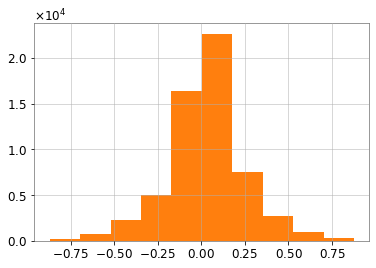

In [8]:
#histogram plots of spin_2z and a_2 times cos_tilt_2 overlapped each other
plt.hist(data['spin_2z'])
plt.hist(data['a_2']*data['cos_tilt_2'])

In [29]:
#This will grab the colors used for our plots
cmap = plt.cm.get_cmap('Set2', 6) #cmap(0)


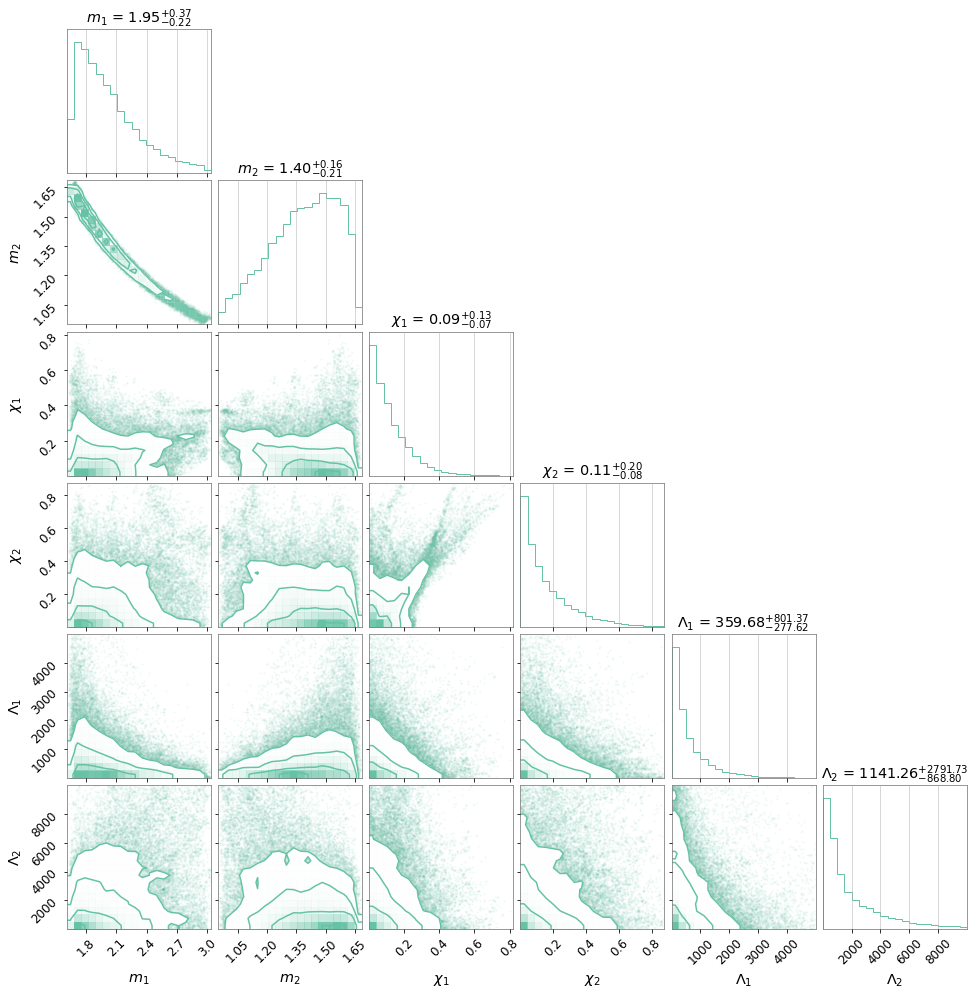

In [10]:
#Corner plot of taken data straight of posterier_samples from C01:IMRPhenomD_NRTidal-HS
figure = corner.corner(data,color = cmap(0),var_names = ["mass_1_source", "mass_2_source",'a_1','a_2',"lambda_1", "lambda_2"],
                       labels = (r"$m_1$",r"$m_2$",r"$\chi_1$",r"$\chi_2$",r"$\Lambda_1$",r"$\Lambda_2$"),
                       show_titles=True) #plot "mass_1_source", "mass_2_source",'a_1','a_2',"lambda_1", and "lambda_2" from h5 file

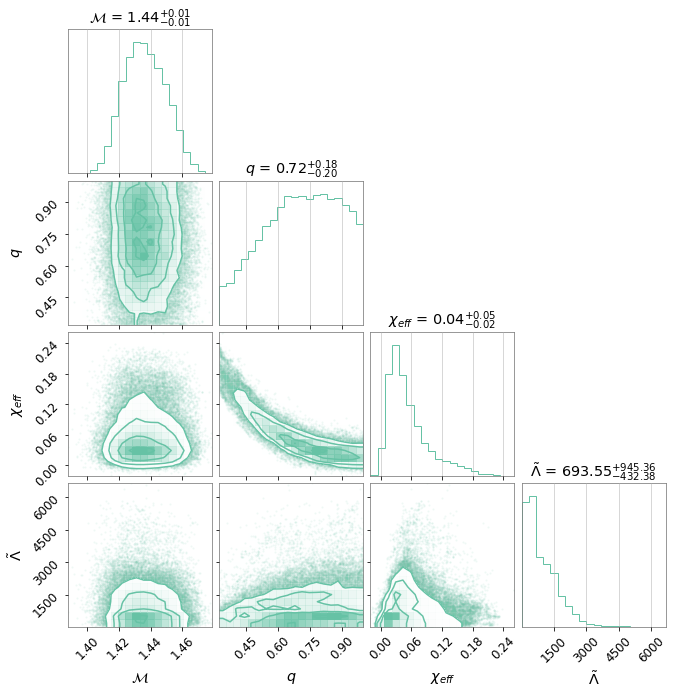

In [11]:
#Plotting using the information of mchirp, mass ratio, chi effective, and lambdatilde
figure = corner.corner(data,color = cmap(0),var_names = ["mchirp","q",'chi_eff',"lambdatilde"],
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True) #plotting the "mchirp","q",'chi_eff', and "lambdatilde" from h5 file

# Consider different Prior assumptions 

In [12]:
#Creating the Priors

#Reminder: 

#Formula: Posterior_Samples = Likelihood * Prior , used to find the Likelihood 
#New Formula: New_Posterior_Samples = Likelihood * New_Prior

old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2_snrcut') # function of m1, m2, lum_dist

# weight samples based on galactic mass prior
data['massweight']  = data.apply(lambda row :
                            new_prior_mass(row['mass_1_source'],row['mass_2_source'],row['luminosity_distance'])  
                            /  old_prior_mass(row['mass_1_source'],row['mass_2_source'],row['luminosity_distance']) 
                            , axis = 1)

# normalize the weights for distribution comparisons
data['massweight']=data['massweight']/data['massweight'].sum() * data['massweight'].size

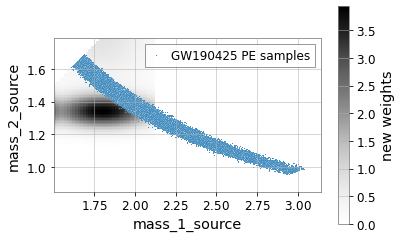

In [13]:
#Meshgrid and Scatter Plot of the PE Samples 

x_coords = np.linspace(min(data['mass_1_source'])-0.1,max(data['mass_1_source'])+0.1,100) #x axis 
y_coords = np.linspace(min(data['mass_2_source'])-0.1,max(data['mass_2_source'])+0.1,100) #y axis
X, Y = np.meshgrid(x_coords, y_coords) #numpy meshgrid of x and y coords
avg_lumdist = data['luminosity_distance'].sum() / data['massweight'].size #Average Luminosity distance 
Z = np.vectorize(new_prior_mass)(X,Y,avg_lumdist) # z axis describing the weights

fig = plt.pcolormesh(x_coords, y_coords, Z, cmap='Greys') #pcolormesh of each coords shown in grey
fig.axes.set_aspect('equal') #fit all parameters to fit in one plot
plt.colorbar(label="new weights")

sns.scatterplot(data=data, x='mass_1_source', y='mass_2_source',  marker=",", s=1, label = "GW190425 PE samples") #Scatter plot of mass_1_source and mass_2_source 
plt.legend()

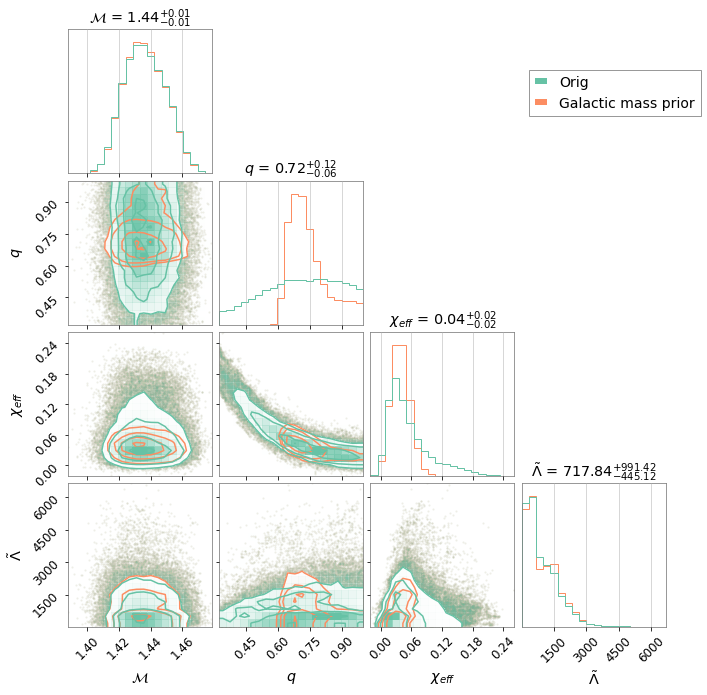

In [14]:
#Corner Plot of Galactic Mass Prior to mchirp, q, chi_eff, lambdatilde
figure = corner.corner(data,weights = data["massweight"], color = cmap(1),var_names = ["mchirp","q",'chi_eff',"lambdatilde"],
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)  #adding the massweights (orange) to known data from h5 file

corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q","chi_eff","lambdatilde"],
              labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$")) 

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(1), label='Galactic mass prior')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 14) #Legend 
plt.show()

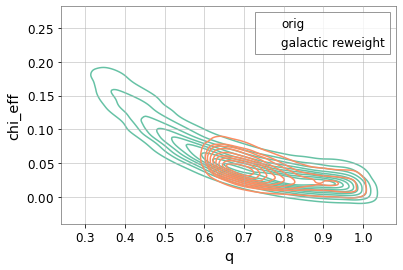

In [30]:
#Q vs Chi_Eff KDS Plot using Galatic reweights

#This will grab the colors used for our plots
cmap = plt.cm.get_cmap('Set2', 6) #cmap(0)

sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(0), label='orig') #Plotting KDE plot of Q and Chi_eff
sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(1), label='galactic reweight',
            weights = data['massweight']) #Adding the weights (orange)
# plt.axes().set_aspect(1./plt.axes().get_data_ratio())
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'aspect'
  **contour_kws,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'aspect'
  **contour_kws,


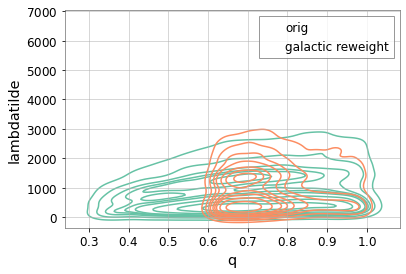

In [31]:
#Lambdatilde vs Q using Galatic Reweights 

#This will grab the colors used for our plots
cmap = plt.cm.get_cmap('Set2', 6) #cmap(0)


sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(0), label='orig',aspect=1) #plotting KDE Lambdatilde vs Q 
sns.kdeplot(data=data, x='q', y='lambdatilde', color=cmap(1), label='galactic reweight',
            weights = data['massweight'],aspect=1) #Adding the mass weights
# plt.axes().set_aspect(1./plt.axes().get_data_ratio())
plt.legend()
plt.show()

In [17]:
#Defined a function to reflect KDEs around hard boundaries 
def reflect(x_reflect, point_reflect):
  diff_reflect = (x_reflect - point_reflect) #Used when the point of reflect is not just 0.
  opp_reflect = point_reflect - diff_reflect #Create the same  values for kde is now in the opposite side of the point of reflect
  return opp_reflect

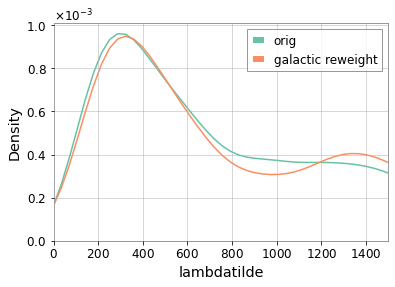

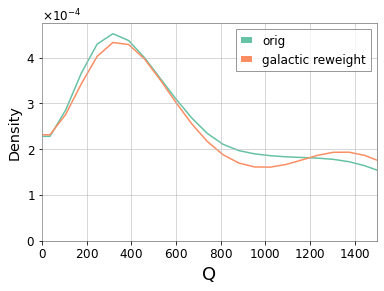

In [18]:
#1-D KDE plot of Lambdatilde. Peak is incorrect. 

# Originial plots before considering the hard boundaries

sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig') 
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='galactic reweight',
            weights = data['massweight']) #Adding Massweights
plt.xlim(0,1500)
plt.legend()
plt.show()


# New plot that considers the hard boundaries

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde']) #

trueKDE_weights = list(data['massweight']) + list(data['massweight']) 


sns.kdeplot(x = trueKDE,  color=cmap(0), label='orig') 
# plt.hist(data['lambdatilde'], density = True, histtype = 'step', bins = 100)
sns.kdeplot(x = trueKDE,  color=cmap(1), label='galactic reweight',
            weights = trueKDE_weights) #Adding Massweights
plt.xlabel('Q', fontsize=18)
plt.xlim(0,1500)
plt.legend()
plt.show()

In [19]:
#Since we sample uniformly in components, this is the prior on lambda_tilde

# Analytic prior
# LT = A L1 + B L2
# LT = z
def unif_component_prior(q,z,Lmax1, Lmax2): 
    mtotal = 1+q
    m1fac= 1+12*q
    m2fac= q+12
    A = 16./13*(m1fac)/mtotal**(5)
    B = 16./13*(m2fac*q**(4))/mtotal**(5)
    norm = A*B *Lmax1*Lmax2
    return  (np.heaviside(z / A,1.) * (
        z + (A * Lmax1 - z) * np.heaviside(z/A - Lmax1,1.) ) - np.heaviside(z/A - B * Lmax2/A, 1.) * (
        z - B * Lmax2 + (A * Lmax1 + B * Lmax2 - z) * np.heaviside(z/A - (A * Lmax1 + B * Lmax2) / A,1.)) )/norm

def lambda_weights(samples,L1max, L2max): #Creating a function for lambda weights. Enforcing a flat lambdatilde
    qsamples = samples["mass_2_source"]/samples["mass_1_source"]
    weights = 1./unif_component_prior(qsamples,samples["lambda_tilde"],L1max, L2max)
    return weights / np.sum(weights) * len(weights)  
# normalize overall weight for histogram comparisons 


# Setting L1 and L2 Maxes
# Lmax=5000 # uniform prior maximum lambda for both components. This was the original value
L1max1 = 5000  
L2max2 =  10000 

<AxesSubplot:xlabel='q', ylabel='lambdatilde'>

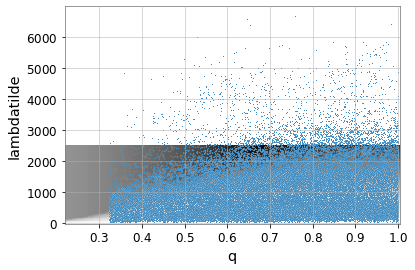

In [20]:
#Scatter plot that describes the pseudocolor and scatter plot of q vs lambdatilde
x_coords = np.linspace(min(data['q']-0.1),max(data['q']),100)
y_coords = np.linspace(0,2500,100)
X, Y = np.meshgrid(x_coords, y_coords)
Z = np.vectorize(unif_component_prior)(X,Y,L1max1,L2max2)
fig = plt.pcolormesh(x_coords, y_coords, Z, cmap='Greys')

sns.scatterplot(data=data, x='q', y='lambdatilde',  marker=",", s=1)

In [ ]:
#reweight to a flat in lambda-tilde prior
data['lambdatweight']  = data.apply(lambda row : 
                                           1/unif_component_prior(row['q'],row['lambdatilde'],L1max1,L2max2), axis = 1)
data['lambdatweight']=data['lambdatweight']/data['lambdatweight'].sum() * data['lambdatweight'].size

print(data['lambdatweight']) #error
print(data['massweight'])

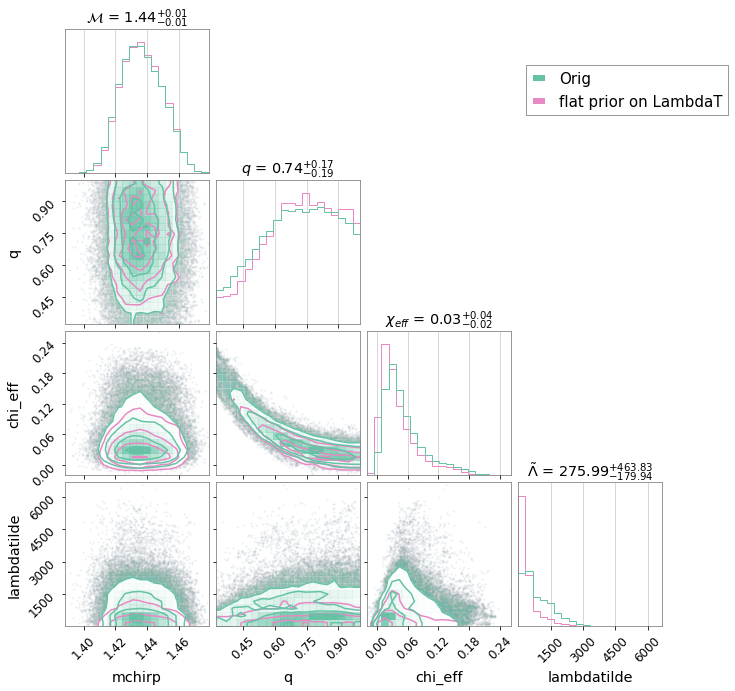

In [22]:
#Corner Plot of lambdatweight flat Prior to mchirp, q, chi_eff, lambdatilde
figure = corner.corner(data, weights = data["lambdatweight"] ,color = cmap(2),var_names = ["mchirp","q",'chi_eff',"lambdatilde"], 
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)
corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q",'chi_eff',"lambdatilde"])

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(2), label='flat prior on LambdaT')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 15)
plt.show()

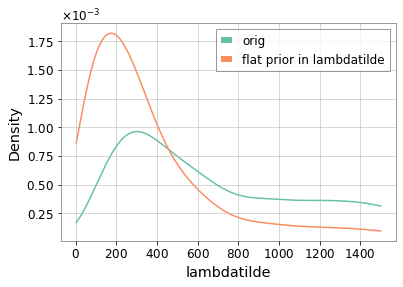

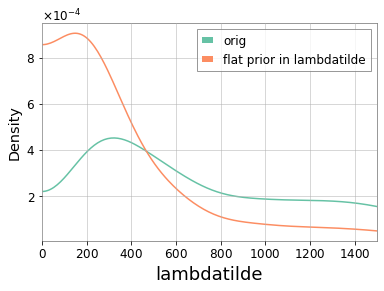

In [23]:
#1-D KDE plot of Lmabdatilde of using a flat prior on lambdatilde


# Originial plots before considering the hard boundaries

sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig',cut=0, clip=(0,1500))
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='flat prior in lambdatilde',
            weights = data['lambdatweight'],cut=0, clip=(0,1500))
plt.legend()
plt.show()


# New plot that considers the hard boundaries

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde'])
# print(data['lambdatilde'])
trueKDE_LambdaT_weights = list(data['lambdatweight']) + list(data['lambdatweight']) #list format? List or Array, Floats or int? 'wide-form data' match to the same list as bellcurve. compare lists of of massweights and lambdaT. 
# print(data['lambdatweight'])

sns.kdeplot(x=trueKDE,  color=cmap(0), label='orig',cut=0, clip=(0,1500))

sns.kdeplot(x=trueKDE,  color=cmap(1), label='flat prior in lambdatilde',
            weights = trueKDE_LambdaT_weights,cut=0, clip=(0,1500))

plt.xlabel('lambdatilde', fontsize=18)
plt.xlim(0,1500)
plt.legend()
plt.show()

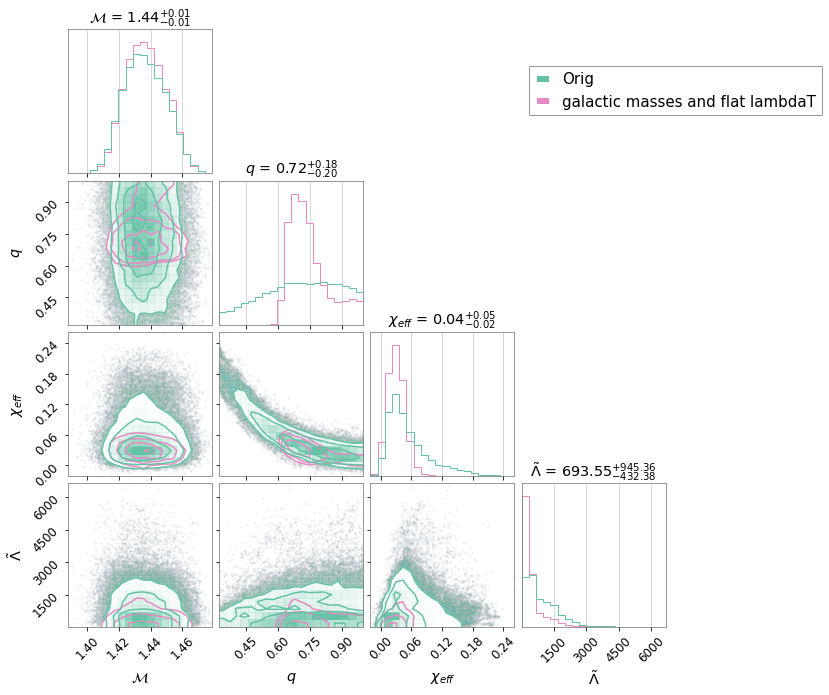

In [24]:
#Corner Plot of galatic mass prior and lambdatweight flat Prior to mchirp, q, chi_eff, lambdatilde
figure = corner.corner(data,weights = data["lambdatweight"]*data["massweight"], color = cmap(2),var_names = ["mchirp","q",'chi_eff',"lambdatilde"])
corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q",'chi_eff',"lambdatilde"],labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(2), label='galactic masses and flat lambdaT')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 15)
plt.show()

plt.show()

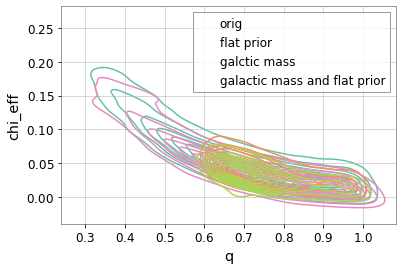

In [32]:
#Q vs Chi_Eff KDS Plot using Galatic reweights and lambdatweight flat prior

sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='q', y='chi_eff', color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(1), label='galctic mass',
            weights = data['massweight'])

sns.kdeplot(data=data, x='q', y='chi_eff',color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
plt.show()

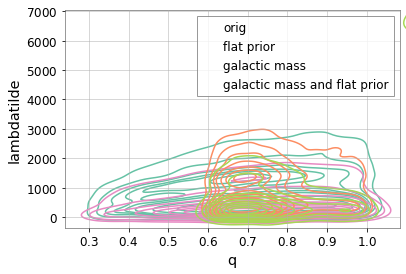

In [33]:
#lambdatilde vs chi_Eff KDS Plot using Galatic reweights and lambdatweight flat prior

sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(1), label='galactic mass ',
            weights = data['massweight'])
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
# plt.xlim(0,1500)
plt.show()

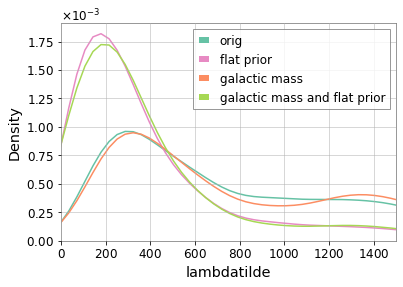

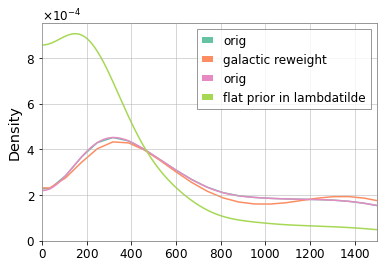

In [34]:
#1-D KDE plot of Galatic reweights and lambdatweight flat prior on lambdatilde

# Originial plots before considering the hard boundaries

sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='galactic mass ',
            weights = data['massweight'])
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
plt.xlim(0,1500)
plt.show()


# New plot that considers the hard boundaries

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde'])
trueKDE_weights = list(data['massweight']) + list(data['massweight']) 
trueKDE_LambdaT_weights = list(data['lambdatweight']) + list(data['lambdatweight'])

##In this section I changed the weights 
sns.kdeplot(x = trueKDE,  color=cmap(0), label='orig') 
# plt.hist(data['lambdatilde'], density = True, histtype = 'step', bins = 100) #If you want to view as a hist

sns.kdeplot(x = trueKDE,  color=cmap(1), label='galactic reweight',
            weights = trueKDE_weights) #Adding Massweights
sns.kdeplot(x=trueKDE,  color=cmap(2), label='orig',cut=0, clip=(0,1500))
sns.kdeplot(x=trueKDE,  color=cmap(3), label='flat prior in lambdatilde',
            weights = trueKDE_LambdaT_weights,cut=0, clip=(0,1500)) 


plt.xlim(0,1500)
plt.legend()
plt.show()